In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/workshops/week3'
FOLDERNAME = 'acmlab/workshops/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/acmlab/workshops/project


In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
from collections import defaultdict, namedtuple
import os

from PIL import Image

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(229)

import pandas as pd

import util # ensure that the npy file is on the same directory as util
import webmercator
from tqdm import tqdm
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # take advantage of GPU

**Part 1:** The first function you should write is `csv_to_data()`. This should take in a filename and returns a dictionary `data` from zipcode to average income.

In [ ]:
def csv_to_data(filename):
    """Takes in a `filename` and returns a dictionary `data` from zipcode to average income.
    For a given row, the average income is computed as 

    row['A02650'] / row['N1']"""
    # Question: do we need the null zipcode?
    # ZIPCODE is the right column for zipcode
    # completed
    dataset = pd.read_csv(filename)
    data = {}
    for row in range(1, len(dataset)):
        data[dataset['ZIPCODE'][row]] = dataset['A02650'][row] / dataset['N1'][row]
    print(dataset) # for debugging
    return data

In [ ]:
data = csv_to_data('16zpallnoagi.csv')      
print(data) # for debugging

       STATEFIPS STATE  ZIPCODE  AGI_STUB  ...  N11901   A11901   N11902   A11902
0              1    AL        0         0  ...  358370  1683323  1583690  4690385
1              1    AL    35004         0  ...     930     3022     4130    11001
2              1    AL    35005         0  ...     430      860     2600     7364
3              1    AL    35006         0  ...     180      315     1010     2873
4              1    AL    35007         0  ...    2590     9648     8950    23317
...          ...   ...      ...       ...  ...     ...      ...      ...      ...
29969         56    WY    83126         0  ...      40      192      120      299
29970         56    WY    83127         0  ...     400     2696      940     2661
29971         56    WY    83128         0  ...     250     1373      600     1715
29972         56    WY    83414         0  ...      50     1145      120      755
29973         56    WY    99999         0  ...    1630    10925     6010    30456

[29974 rows x 1

**Part 2:** you should write the `load_zip_latlon_info` function. This function should:

- Take in a filename representing a path to a latitude/longitude data file with the following columns of interest:
    - `zip`: the zipcode
    - `state`: the state of the zipcode
    - `latitude`, `longitude`: the latitude and longitude of the zipcode
- Keep only zipcodes that are in our `data` dictionary.
- Convert the latitude and longitude to `x, y` values. (The `webmercator.xy(lat, lon, z)` function may be helpful here.)
- Create a dictionary from zipcode to `(x, y)` tuples.

In [ ]:
def load_zip_latlon_info(filename): # Last Edited: Oct 28th
    """Takes in a `filename` and returns a dictionary from zipcode to (x, y)."""
    df = pd.read_csv(filename, sep=';')                     # the datafile is separated by semicolons for some reason
    df = df[df['state'] == 'CA']                            # will make your code more efficient to only work on CA
    zip_to_latlon = {}
    for idx, row in df.iterrows():                        # loop through the rows of the dataframe
        x, y = webmercator.xy(df['latitude'][idx], df['longitude'][idx], 14) # fill this out
        if (2794 <= x <= 2839) and (6528 <= y <= 6572):     # only zip codes in the data set
            zip_to_latlon[row['zip']] = (x, y)  
    return zip_to_latlon

In [ ]:
zip_to_latlon = load_zip_latlon_info('ziplatlon.csv')
data = dict([kv for kv in data.items() if kv[0] in zip_to_latlon])
print(data)        # Only keep zipcodes in the 

{90001: 28.594139363174897, 90002: 28.314328808446454, 90003: 26.77940637596189, 90004: 71.75785688601222, 90005: 50.961703470031544, 90006: 29.795523685354194, 90007: 30.304516640253567, 90008: 52.619015957446805, 90010: 219.34897119341565, 90011: 26.776114732724903, 90012: 58.78833474218089, 90013: 75.38333333333334, 90014: 81.7919770773639, 90015: 72.19791907514451, 90016: 42.65792764627066, 90017: 70.87924921793535, 90018: 37.746850928862706, 90019: 53.70663474692203, 90020: 66.69717764250139, 90021: 105.01159420289855, 90022: 33.93567821067821, 90023: 31.06272677295217, 90024: 364.07481824190353, 90025: 198.24428404213813, 90026: 54.093314411857456, 90027: 89.49915682967959, 90028: 49.16011787819254, 90029: 37.84497354497355, 90031: 37.31180722891566, 90032: 42.16275201612903, 90033: 30.596745230078565, 90034: 72.92488614183475, 90035: 106.22087205146534, 90036: 111.64958634953464, 90037: 26.997560975609755, 90038: 45.956048084147255, 90039: 81.1437917222964, 90040: 55.55825932504

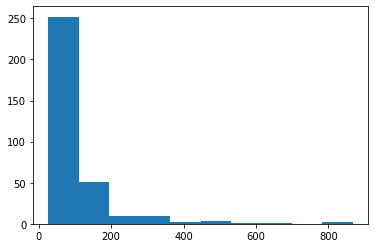

In [ ]:
plt.hist(list(data.values()))
plt.show()

**Part 3:** Write a function `euclidean_distance` that takes in two (x, y) tuples and returns the **squared** Euclidean distance between the two points.

In [ ]:
def euclidean_distance(pt1, pt2):
    return (pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2 # fill this out (Done, Oct 22)

**Part 4**: Write the dataset. The comments should be helpful in walking you through it.

For more understanding of how a dataset works, please consult the project handout.

Our implementation of the dataset takes about 6 minutes to finish running.  There are definitely more efficient ways to do it.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, main_dir, transform, data, zip_to_latlon):
        self.main_dir = main_dir
        self.transform = transform
        self.data = data
        self.zip_to_latlon = zip_to_latlon
        
        
        self.latlons = []
        self.total_imgs = []
        oceanic = 0

        # This loops through all the images in the directory.
        for filename in tqdm(sorted(os.listdir(main_dir))):             # tqdm lets you get a nice progress bar
            # Step 1: if the filename is not a .jpg, continue. (Last Edited: Oct 22)
            if (filename[-4:] != ".jpg"):
                continue
    
            # Step 2: extract the x and y values out of the filename.
            # Remember that a filename is of the form: 14_2817_6565.jpg 
            # where x=2817, y=6565. (Last Edited: Oct 22)
            nums = filename.split("_")
            x, y = int(nums[1]), int(nums[2].split(".")[0].split("(")[0])
            

            # Step 3: check if the tile is oceanic (i.e. has elevation 0). Last Edited Oct 28
            # The util.getElevation function takes in a **latitude** and **longitude** and returns an elevation.
            # To get a latitude and longitude from a x and y, use `webmercator.latlon(x, y, z=14)`.
            # If it is, ignore it.
            
            latitude, longitude = webmercator.latlon(x, y, z=14)
            elevation = util.getElevation(latitude, longitude)
            if elevation == 0:
                continue

            # Step 4: Append (x, y) to the self.latlons list. Last Edited Oct 28
            self.latlons.append((x, y))

            image = Image.open('imagery/' + filename).convert("RGB")
            self.total_imgs.append(image)
            
        self.zipcodes = []                                              # a list of zipcodes 
        self.tile_to_zipcode = {}
        # get the list of zip codes we need
        for zipcode, (zipcode_x, zipcode_y) in zip_to_latlon.items():   # loops through zipcodes and their x, y coordinates
            for x, y in self.latlons:                                   
                if self.in_tile((zipcode_x, zipcode_y), (x, y)) and zipcode in data:        # check if this zipcode is in the tile
                    # print(zipcode, x, y)
                    self.zipcodes.append(zipcode) 
                    self.tile_to_zipcode[(x, y)] = zipcode

        for idx, (x, y) in enumerate(self.latlons):
            if (x, y) not in self.tile_to_zipcode:                      # if this tile isn't already assigned
                # find the closest zipcode
                # you can use the `min(self.zipcodes, key=FUNCTION)` here
                min = 999999
                for zipcode in self.zipcodes:
                    if euclidean_distance(self.zip_to_latlon[zipcode], (x, y)) < min:
                        min = euclidean_distance(self.zip_to_latlon[zipcode], (x, y))
                        best_zipcode = zipcode

                self.tile_to_zipcode[(x, y)] = best_zipcode

        print(len(self.tile_to_zipcode), "entries.")
                
    def __len__(self):
        """Return the length of the dataset—how many images there are, total."""
        return len(self.data) # Last edited Oct 22
    
    def coordinates(self, zipcode):
        """Returns the coordinates of the given zipcode."""
        return self.zip_to_latlon[zipcode]     # Last edited Oct 28
    
    def in_tile(self, coord, square):
        """checks whether a given coordinate is in a tile"""
        lat, lon = coord
        llat, llon = square
        ulat, ulon = llat + 1, llon + 1
        return (lat >= llat and lon >= llon and lat <= ulat and lon <= ulon)
  
    def get_image(self, idx):
        """Returns the image at this index."""
        return self.total_imgs[idx]     # Last edited Oct 28

    def get_label(self, idx):
        """Given an index, return the ground truth label for that index."""
        (x, y) = self.latlons[idx]
        zipcode = self.tile_to_zipcode[(x, y)]
        return self.data[zipcode]     # fill this in
    
    def __getitem__(self, idx):
        """Return the image and label at a given index"""
        tensor_image = self.transform(self.get_image(idx)) # Last edited Oct 28
        label = self.get_label(idx) # Last edited Oct 28
        return tensor_image, label
    
    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

In [ ]:
dset = ImageDataset('imagery', ToTensor(), data, zip_to_latlon)
print(data)

100%|██████████| 2000/2000 [08:16<00:00,  4.03it/s]


1457 entries.
{90001: 28.594139363174897, 90002: 28.314328808446454, 90003: 26.77940637596189, 90004: 71.75785688601222, 90005: 50.961703470031544, 90006: 29.795523685354194, 90007: 30.304516640253567, 90008: 52.619015957446805, 90010: 219.34897119341565, 90011: 26.776114732724903, 90012: 58.78833474218089, 90013: 75.38333333333334, 90014: 81.7919770773639, 90015: 72.19791907514451, 90016: 42.65792764627066, 90017: 70.87924921793535, 90018: 37.746850928862706, 90019: 53.70663474692203, 90020: 66.69717764250139, 90021: 105.01159420289855, 90022: 33.93567821067821, 90023: 31.06272677295217, 90024: 364.07481824190353, 90025: 198.24428404213813, 90026: 54.093314411857456, 90027: 89.49915682967959, 90028: 49.16011787819254, 90029: 37.84497354497355, 90031: 37.31180722891566, 90032: 42.16275201612903, 90033: 30.596745230078565, 90034: 72.92488614183475, 90035: 106.22087205146534, 90036: 111.64958634953464, 90037: 26.997560975609755, 90038: 45.956048084147255, 90039: 81.1437917222964, 90040: 

This code block creates train and validation dataloaders.

In [ ]:
validation_split = 0.10
dataset_size = len(dset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
train_dataloader = DataLoader(dset, batch_size=32, sampler=train_sampler)
valid_dataloader = DataLoader(dset, batch_size=32, sampler=valid_sampler)

**Step 5**: Create the model.  Workshop 3 may be useful for this.
We suggest a series of convolutional layers interspersed with `torch.nn.MaxPool2d` layers, followed by a series of linear layers.
Each convolutional and linear layer should be followed by an activation function.

In [ ]:
import torchvision # I saw these needed to be imported to fix the error, but they are also imported above so I guess we can delete when training/testing when we run the entire notebook. 
import torch
import torch.nn.functional as F

class Model(torch.nn.Module): # Edited by Rohan on Oct 28
    def __init__(self):
        super(Model, self).__init__()
        # define your layers
        # 1st conv. layer with in_channel = 3 since the images are RGB.
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        # pool layer (only need to define once and then pass it through for each conv. layer in forward)
        self.pool = torch.nn.MaxPool2d(2, stride = 2)
        # 2nd. conv. layer
        self.conv2 = torch.nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5)
        # fully connected layers
        self.fc1 = torch.nn.Linear(in_features = 12*61*61, out_features=30) # we aim to eventually get the out_features = 1 since this is a regression task.
        self.fc2 = torch.nn.Linear(in_features = 30, out_features = 15)
        self.fc3 = torch.nn.Linear(in_features = 15, out_features = 10)
        self.fc4 = torch.nn.Linear(in_features = 10, out_features = 1) 
        # final out_features = 1: the income prediction
        
    def forward(self, x):
        # run your data through the layers
        x = self.pool(F.relu(self.conv1(x))) # use relu activation and pass 1st conv. layer through pool
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.size())
        # convert to correct tensor shape for linear fc layers
        x = x.view(-1, 12*61*61)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x.squeeze()  

**Step 6**: Train the model. Use `torch.nn.MSELoss(reduction='sum')` here, or one of the other losses specified in the project spec, since we're trying to output a real value (not categories). 

In [ ]:
# train loop
# Last edited Nov 1
import matplotlib.pyplot as plt 

model = Model().to(device=device) # to let the model run on GPU
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

writer = SummaryWriter()

num_epochs = 200
for epoch_num in range(num_epochs):
    avg_train_loss = 0
    avg_train_l1 = 0
    for i, (img_batch, label) in enumerate(train_dataloader):
        img_batch = img_batch.cuda()
        img_batch.requires_grad = True
        label = label.cuda().float() 
        
        # Step 1: feed your predictions into the model, outputting a variable `pred`
        optimizer.zero_grad()
        pred = model(img_batch).float() # Edited Oct 29

        # Step 2: calculate the loss w.r.t the predictions and the labels
        loss = criterion(pred, label) # Edited Oct 29 
        #index = loss.cpu().data.numpy().argmax()  # for graph 
        #plt.scatter(epoch_num, index)  # for graph 
        loss.backward()


        avg_train_loss += loss.detach()
        avg_train_l1 += torch.abs(pred - label).sum()
        torch.nn.utils.clip_grad_norm(model.parameters(), 10)
        optimizer.step()

    avg_train_loss /= len(train_indices)
    avg_train_l1 /= len(train_indices)

    with torch.no_grad():
        model.eval()
        avg_val_loss = 0
        avg_val_l1 = 0
        for i, (img_batch, label) in enumerate(valid_dataloader):
            img_batch = img_batch.cuda()
            label = label.cuda().float()

            # Step 1: feed your predictions into the model, outputting a variable `pred`
            pred = model(img_batch).float() # Edited Oct 29

            # Step 2: calculate the loss w.r.t the predictions and the labels
            loss = criterion(pred, label) # Edited Oct 29 ??

            avg_val_loss += loss
            avg_val_l1 += torch.abs(pred - label).sum()
            
        avg_val_loss /= len(val_indices)
        avg_val_l1 /= len(val_indices)
        
    print(epoch_num, float(avg_train_loss), float(avg_val_loss), float(avg_train_l1), float(avg_val_l1))

#plt.show() # show graph at end. Lower loss the better. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 193722.578125 26973.873046875 333.5314025878906 96.6898422241211
1 21567.720703125 22409.177734375 98.3614501953125 96.87732696533203
2 19837.57421875 23767.36328125 98.28436279296875 85.35328674316406
3 19364.7421875 20601.650390625 92.29324340820312 93.18605041503906
4 18535.947265625 21098.97265625 92.32388305664062 86.01561737060547
5 17864.931640625 24950.994140625 86.46041107177734 86.25006866455078
6 18357.685546875 19463.517578125 92.18688201904297 97.6584243774414
7 17453.806640625 24658.46484375 87.49386596679688 145.6591033935547
8 18261.197265625 20082.373046875 93.98056030273438 88.18907165527344
9 16718.560546875 29589.14453125 84.8465576171875 162.3064422607422
10 17622.658203125 19366.6640625 91.957275390625 101.63297271728516
11 15496.453125 21276.576171875 87.26004791259766 85.87271118164062
12 14885.9248046875 24844.828125 80.74359130859375 85.21513366699219
13 15606.197265625 21888.10546875 81.16656494140625 86.90512084960938
14 14071.9033203125 20937.08203125 72.

In [ ]:
torch.save(model, 'regressionist')


In [ ]:
def predict(img_path):
    from PIL import Image
    from torchvision.transforms import ToTensor
    
    load_model = torch.load('regressionist')
    image = Image.open(img_path).convert('RGB')
    image = ToTensor()(image).unsqueeze(0)
    image = image.cuda()
    prediction = load_model(image)
    return prediction.item()

# img_path="/data/v_PlayingSitar_g25_c04_0256.jpeg"
# picture = 'imagery/14_2754_6258.jpg'
# load_model('imagery/14_2754_6528.jpg')
predict('imagery/14_2794_6529.jpg')

101.2066650390625

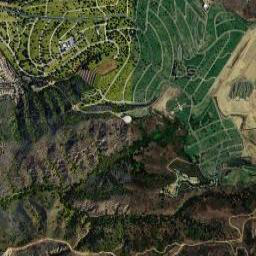

63.400718015665795
tensor(104.8841, device='cuda:0', grad_fn=<SqueezeBackward0>)


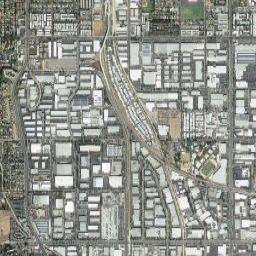

91.29127155172414
tensor(87.2488, device='cuda:0', grad_fn=<SqueezeBackward0>)


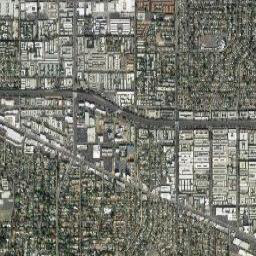

123.99522807017544
tensor(129.6491, device='cuda:0', grad_fn=<SqueezeBackward0>)


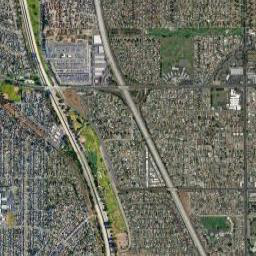

74.71770538243626
tensor(51.6556, device='cuda:0', grad_fn=<SqueezeBackward0>)


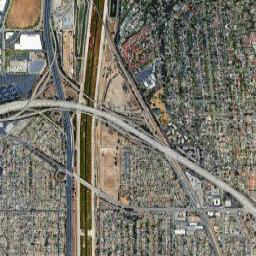

41.89093064611737
tensor(75.0347, device='cuda:0', grad_fn=<SqueezeBackward0>)


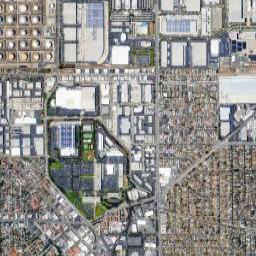

66.18976799524093
tensor(55.9016, device='cuda:0', grad_fn=<SqueezeBackward0>)
15.597294394961706


In [ ]:
for i in [700, 3, 52, 611, 458, 299]:
    display(dset.total_imgs[i])
    print(dset[i][1])
    print(model(dset[i][0].unsqueeze(0).cuda()))
total_sum = 0
for i in range(len(dset)):
    total_sum = total_sum + abs(model(dset[i][0].unsqueeze(0).cuda()).item() - dset[i][1])
print(total_sum / len(dset))

In [ ]:
for i, (img_batch, label) in enumerate(valid_dataloader):
            img_batch = img_batch.cuda()
            label = label.cuda().float()

            # Step 1: feed your predictions into the model, outputting a variable `pred`
            pred = model(img_batch).float() # Edited Oct 29

            # Step 2: calculate the loss w.r.t the predictions and the labels
            loss = criterion(pred, label) # Edited Oct 29 ??

            avg_val_loss += loss
            avg_val_l1 += torch.abs(pred - label).sum()
            
avg_val_loss /= len(val_indices)
avg_val_l1 /= len(val_indices)
print("loss: ", avg_val_loss)
print("l1: ", avg_val_l1)

loss:  tensor(21573.2188, device='cuda:0', grad_fn=<DivBackward0>)
l1:  tensor(97.5348, device='cuda:0', grad_fn=<DivBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Visualization

In [ ]:
#predict function
def predict(filename):
  model = Model();
  total_imgs = []
  image = Image.open('imagery/' + filename).convert("RGB")
  total_imgs.append(image)
  outputs = model(total_imgs.to(device=device))
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)
